# imports

In [43]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans


#### load data and model

In [44]:
data = pd.read_csv("../data/final_dataset_english_only.csv")

genre_counts = data["genre"].value_counts()
valid_genres = genre_counts[genre_counts >= 500].index
data = data[data["genre"].isin(valid_genres)].reset_index(drop=True)

print(f"Remaining genres: {len(valid_genres)}")
print(f"Remaining comments: {len(data)}")

model = SentenceTransformer("all-MiniLM-L6-v2")


Remaining genres: 233
Remaining comments: 352302


#### embeed

In [45]:
embeddings = model.encode(
    data["preprocessed_comment"].astype(str).tolist(),
    show_progress_bar=True,
    batch_size=256
)

Batches:   0%|          | 0/1377 [00:00<?, ?it/s]

#### run clustering

In [46]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

data["cluster"] = cluster_labels

data.to_csv("../data/final_dataset_with_clusters.csv", index=False)


In [47]:
data.head()

,Unnamed: 0,commentId,authorChannelId,authorDisplayName,authorChannelUrl,publishedAt_x,updatedAt,likeCount_x,parentId,textDisplay,...,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji,cluster
0,10,UgxrR4wFxfCwvp2YUwZ4AaABAg,UC5jUy6FXCr82JYzq96-6_Jw,@a.m_0056skycloud-xf5ec,http://www.youtube.com/@a.m_0056skycloud-xf5ec,2025-07-10T11:05:10Z,2025-07-10T11:05:10Z,0,NaN,This is on of her best songs.🌊,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.29,0
1,14,Ugw-qH8WQZqma_AugoN4AaABAg,UCPj69nCAxIJCqD0gKRjGGhA,@angelinamidbjerlundholm3058,http://www.youtube.com/@angelinamidbjerlundholm3058,2021-11-19T21:16:40Z,2021-11-19T21:16:40Z,0,NaN,Right,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,6
2,15,UgywUe9rW4J6ynYErt54AaABAg,UCImqCrcNrl7S1NvrmleWDsg,@thesnesgeek,http://www.youtube.com/@thesnesgeek,2021-04-08T06:18:53Z,2021-04-08T06:18:53Z,2,NaN,"This is her best entry. This time, she is a confident pop diva who delivers great emotion and precense.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3
3,17,UgzgxTaLTsQN9OPizbR4AaABAg,UC4YwlR3gBH0m8pvcDIOspaA,@fingerstylemelody8139,http://www.youtube.com/@fingerstylemelody8139,2020-11-26T06:59:25Z,2020-11-26T06:59:25Z,0,NaN,Great,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8
4,18,UgxoGDPYm0L0XFpNoUJ4AaABAg,UC4i1M5RayNtzd5f6Wuyr5sQ,@sarariley8696,http://www.youtube.com/@sarariley8696,2020-07-05T13:10:56Z,2020-07-05T13:10:56Z,2,NaN,This song reminds me of a murder case 4 years ago as of July 10th this year in Denmark that is still unsolved to thi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.36,7


#### Genre distribution

In [48]:
data['cluster'].value_counts()

cluster
6    66460
1    58239
2    46940
9    34249
7    34096
3    33243
4    25353
0    22610
8    21493
5     9619
Name: count, dtype: int64

#### top cluster per genre

In [50]:
genre_cluster_counts = pd.crosstab(data["genre"], data["cluster"])

genre_totals = genre_cluster_counts.sum(axis=1)

genre_cluster_percent = genre_cluster_counts.div(genre_totals, axis=0) * 100

genre_cluster_long = (
    genre_cluster_percent
    .stack()
    .reset_index()
    .rename(columns={0: "Percentage", "genre": "Genre", "cluster": "Cluster"})
)

genre_cluster_long["Count"] = genre_cluster_long.apply(
    lambda row: genre_cluster_counts.loc[row["Genre"], row["Cluster"]], axis=1
)

genre_cluster_long = genre_cluster_long.sort_values(by="Percentage", ascending=False)

print(genre_cluster_long.head(20))


                 Genre  Cluster  Percentage  Count
361        country pop        1   31.405694    706
76               anime        6   30.965251    401
741               folk        1   30.871492    418
2236  video game music        6   30.625584    328
2321           worship        1   30.321911    584
926         glitch hop        6   30.224643    444
2226         vaporwave        6   30.124777    507
152              bebop        2   29.938543    341
1581        piano rock        1   29.629630    592
2327           worship        7   29.543094    569
216          breakbeat        6   29.379892    488
286           chiptune        6   29.158879    312
1061        indie folk        1   28.940143    527
266   chaotic hardcore        6   28.775357    383
351            country        1   28.321839    616
176           big beat        6   28.092486    486
326             comedy        6   27.947429    723
1791       quiet storm        1   27.866401    559
1016     hardcore punk        6

#### 10 representive comments

In [51]:

N = 10
representatives = []

for cluster_id in range(k):
    # Get indices of all samples in this cluster
    idx = np.where(data["cluster"] == cluster_id)[0]
    if len(idx) == 0:
        continue

    # Compute distance of each sample to the cluster centroid
    cluster_embeddings = embeddings[idx]
    distances = np.linalg.norm(cluster_embeddings - kmeans.cluster_centers_[cluster_id], axis=1)

    # Sort by distance (closest first)
    sorted_idx = idx[np.argsort(distances)]

    # Take top N
    for rank, i in enumerate(sorted_idx[:N]):
        representatives.append({
            "Cluster": cluster_id,
            "Rank": rank + 1,
            "Genre": data.loc[i, "genre"],
            "Comment": data.loc[i, "preprocessed_comment"]
        })

# Convert to DataFrame
rep_df = pd.DataFrame(representatives)

N = 10

for cluster_id in range(k):
    # Indices of samples in this cluster
    idx = np.where(data["cluster"] == cluster_id)[0]
    if len(idx) == 0:
        continue

    # Distances to centroid
    cluster_embeddings = embeddings[idx]
    distances = np.linalg.norm(cluster_embeddings - kmeans.cluster_centers_[cluster_id], axis=1)

    # Sort by distance
    sorted_idx = idx[np.argsort(distances)]

    # Header
    print(f"\nCluster {cluster_id}")
    print("-" * 70)

    # Print top N
    for i in sorted_idx[:N]:
        genre = data.loc[i, "genre"]
        comment = data.loc[i, "preprocessed_comment"]
        print(f"{genre} | {comment}")

    print("-" * 70)



Cluster 0
----------------------------------------------------------------------
k-pop | i rlly love it💝
roots reggae | much love from 🇵🇷
jazz | 💖🥰🎈 loveem❣ love it 💖🥰🎈🙏 fantastic❣
edm | wooow😯😯 i really love this😍😍
chillwave | i love 🥰💖warm bodies💖🥰
motown | i love ❤️ them🎉❤😊
nu metal | i love windows🗣️🗣️🗣️🗣️🗣️🗣️🗣️🗣️🗣️🗣️ 🪟
soft rock | 🥀beautiful sad love song🥀✌
grunge | freaking phenomenal🔥⚡️♠️♠️ thankyou🙏
futurepop | hell yeah beautiful😁😈 😎🤘🔊🔊🎶🎹🖤🔥☣👻🧟‍♀️💀
----------------------------------------------------------------------

Cluster 1
----------------------------------------------------------------------
pop punk | im so love this song
jazz fusion | i stil love this song
art rock | i realy love this song
smooth jazz | i loved this song so much
krautrock | one of the greatest songs ever i love this song
freak folk | im super loving this song
wonky | i loveee this song so beautiful
riot grrrl | just adore this song so much
soul | i love this song soo much
cool jazz | i love this song 

##### correlation matrix

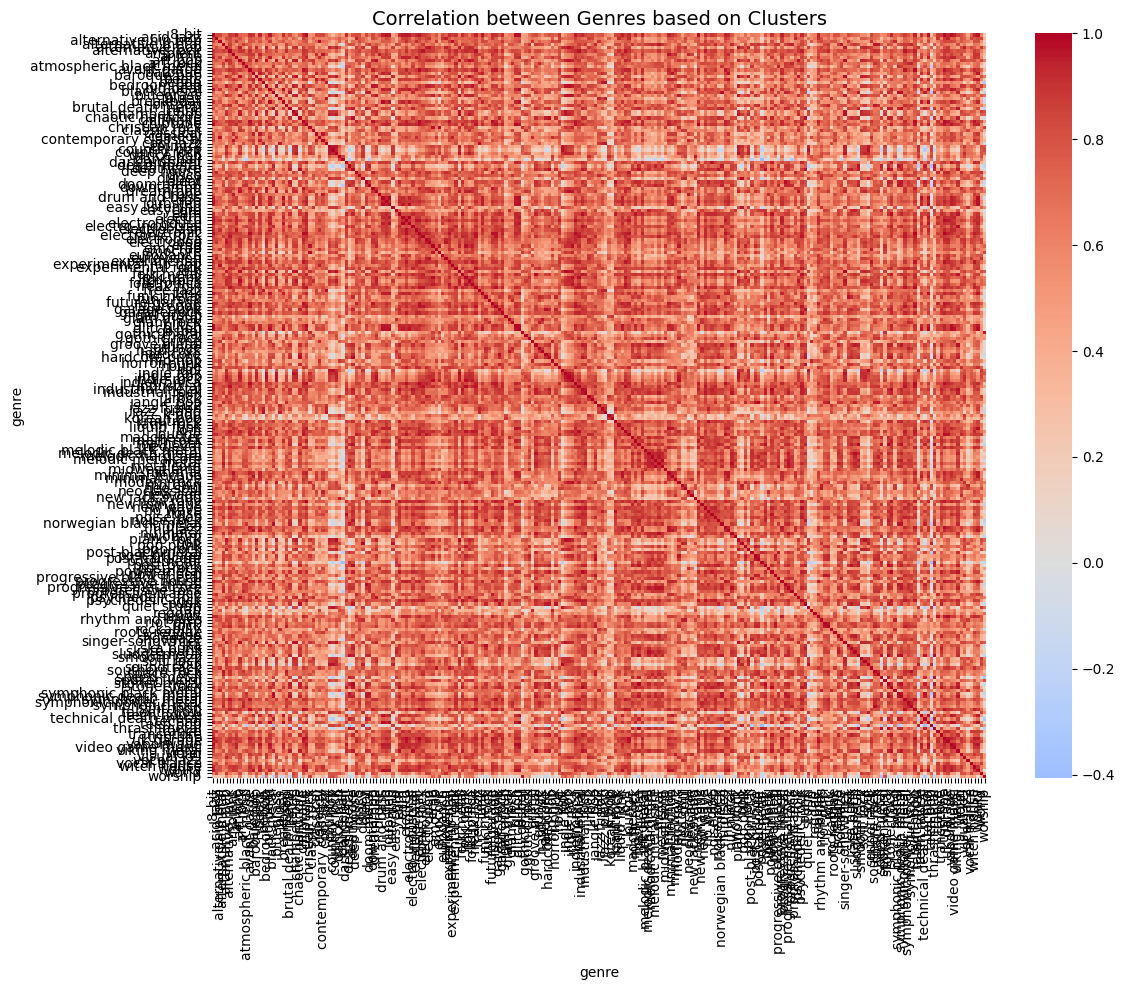

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: contingency table (genres × clusters)
genre_cluster_matrix = pd.crosstab(data["genre"], data["cluster"])

# Step 2: compute correlations between genres
genre_corr = genre_cluster_matrix.T.corr(method="pearson")

# Step 3: plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genre_corr, cmap="coolwarm", center=0,
            xticklabels=True, yticklabels=True)
plt.title("Correlation between Genres based on Clusters", fontsize=14)
plt.tight_layout()
plt.show()


#### top and bottom correlating genres

In [53]:
import numpy as np

# Make sure the correlation matrix axes have distinct names
genre_corr.index.name = "Genre1"
genre_corr.columns.name = "Genre2"

# Take only the upper triangle (k=1 excludes the diagonal), then flatten
pairs = (
    genre_corr
    .where(np.triu(np.ones(genre_corr.shape), k=1).astype(bool))
    .stack()
    .rename("Correlation")
    .reset_index()
)

# Top 10 most correlated genre pairs
top10_corr = pairs.sort_values("Correlation", ascending=False).head(10)
bottom10_corr = pairs.sort_values("Correlation", ascending=False).tail(10)
print("top correlating genres: ")
print(top10_corr[["Genre1", "Genre2", "Correlation"]])
print("----"*10)
print("bottom correlating genres: ")
print(bottom10_corr[["Genre1", "Genre2", "Correlation"]])


top correlating genres: 
           Genre1             Genre2  Correlation
21642    mathcore       stoner metal     0.996320
14582        folk  singer-songwriter     0.994002
17280  glitch hop             techno     0.992272
6235     chiptune           new rave     0.991720
11629         edm      electro house     0.991606
12641  electronic           synthpop     0.991329
6180     chiptune             glitch     0.990192
12650  electronic           trip hop     0.989238
14550        folk         piano rock     0.988098
12539  electronic       indietronica     0.987669
----------------------------------------
bottom correlating genres: 
                      Genre1       Genre2  Correlation
3591                   bebop      worship    -0.303483
4220             black metal     teen pop    -0.308511
24796             post-metal  talent show    -0.309409
26874  technical death metal      worship    -0.315443
26562            speed metal      worship    -0.325998
26686  symphonic black met

In [55]:
pairs.to_csv('../data/correlation_pairs.csv')